#### Run Saint Laurent De Jourdes Simulation for  when the controlled HV Prod is 
- not injecting into the network;
- injecting into the network with no constraints considered;
- injecting into the network with a maximum Voltage Rise threshold considered on the HV buses.

Function file created

In [2]:
#Import Modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp
import math as mt
import pandapower.plotting as pt
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib


In [78]:
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc

from oriVariables import (network_folder, 
                          excel_folder, 
                          Δt, 
                          attr_list,
                          lowerNet_file_loc, 
                          upperNet_file_loc, 
                          trainSet_start,
                          ctrld_HvProd_name,
                          defAuth_hvBus_vRiseMax,
                          defAuth_hvBus_vRiseMin,
                          simResult_folder
                          )

#Import Networks
lowerNet=pp.from_pickle(lowerNet_file_loc)
upperNet=pp.from_pickle(upperNet_file_loc)

Compute the total power  of BT prod and Load on St Laurent 


In [7]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =upperNet.sgen[upperNet.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = upperNet.load.max_p_mw.sum()
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


In [9]:
row2read = 8784 # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100
upscale_factor = 10


# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, row2read)
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder, row2read)
p_mw_0100 = p_mw_0013*upscale_factor   # Due to the fact that in 2020 p0100 was not working yet
p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder,row2read)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder, row2read)

# Create index to use for dataframe
per_index = pd.period_range(trainSet_start, periods=len(p_mw_0013), freq='10T')


# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013, 
                'P0018': p_mw_0018,
                'P0100': p_mw_0100}

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# # Dataframe prod BT 
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index)

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = lowerNet.sgen.max_p_mw[lowerNet.sgen.name.isna()].sum()

# Get total power of load in the network
max_p_mw_total_load = lowerNet.load.max_p_mw.sum()

#### Plot Total prod BT and Total Load demand

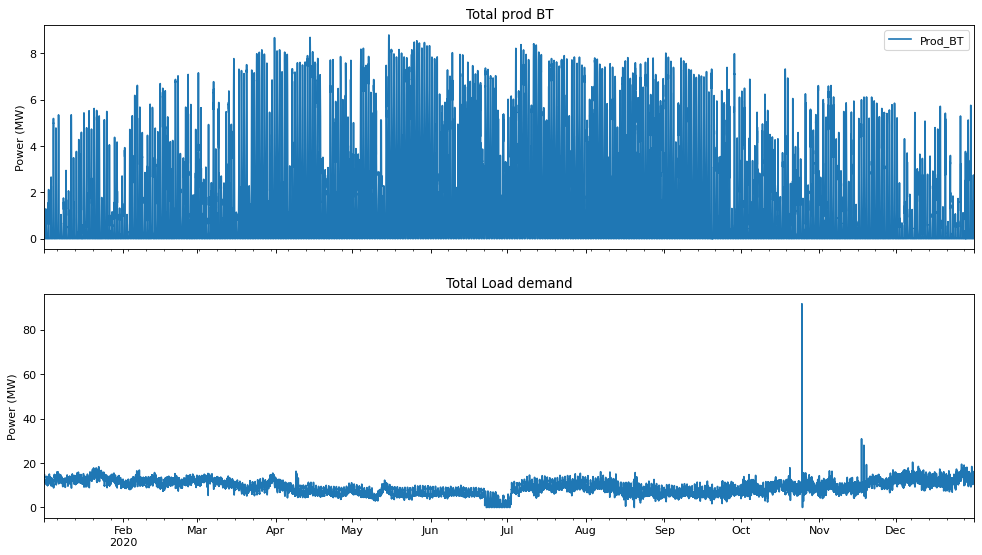

In [10]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total[0].plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

In the previous figure, the pic of demand occurring toward the end of October does not make sense. The disparity is undoubtedly due to a recording error. We will replace the recorded value with the mean of the previous and following periods

In [11]:
max_indx = df_cons_total[0].argmax()  # Get the indice of the period where the pic occurs

# replace the value with the mean of the previous and following periods
df_cons_total[0][max_indx] = (df_cons_total[0][max_indx-1] + df_cons_total[0][max_indx-1])/2

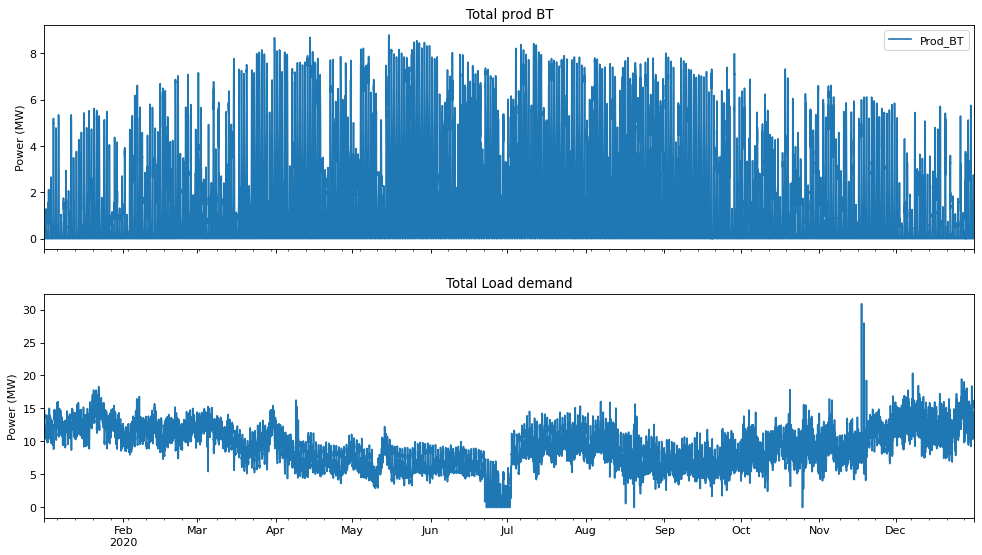

In [12]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total[0].plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Zoom on the end of june of the total demand

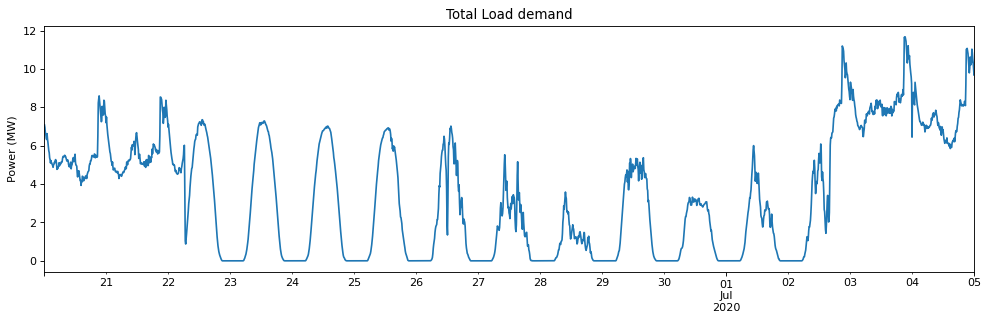

In [13]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

<div class="alert alert block alert-danger ">
    <b>Important:</b> Total load demand follows a PV production cycle like from 2020-06-22 to 2020-07-03 included   
</div>    

#####  Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [14]:
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

#### Check wether the wrong data have been replaced

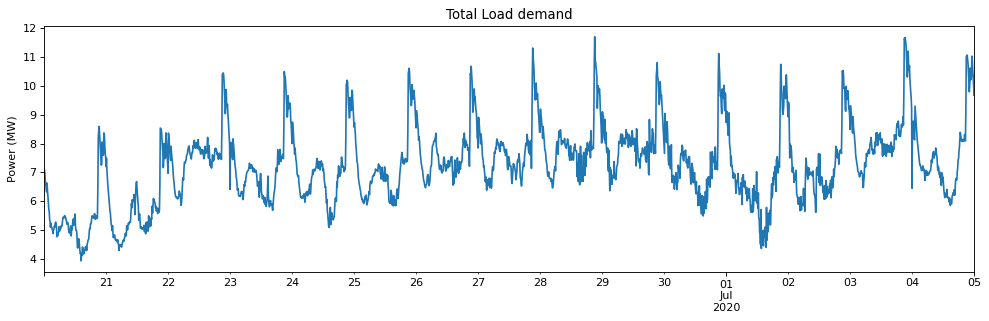

In [15]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Plot Total prod HT 

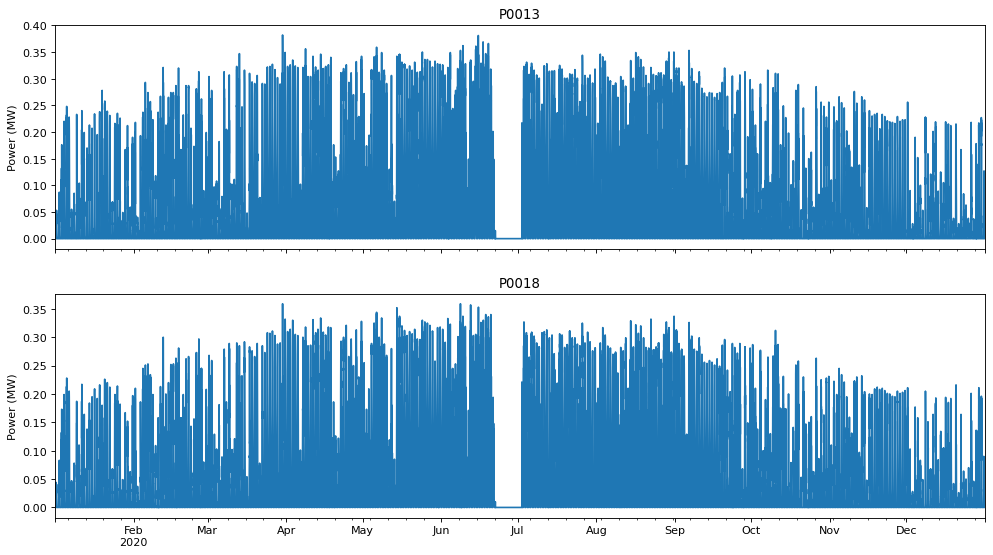

In [16]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');

### Highlight where data is missing

<AxesSubplot:>

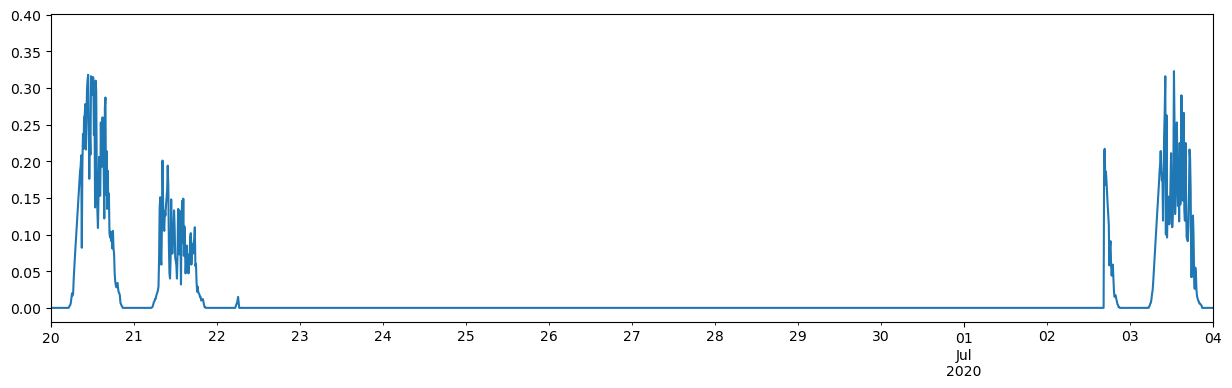

In [17]:
df_prodHT['P0013'].plot(xlim=('06 20 2020', '07 04 2020'), figsize=(15,4))

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b>
11 Days of data are missing (06-22 to 07-03)
</div>

##### Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [18]:
# Extract previous and following days 
previous_days = df_prodHT[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_prodHT[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]

# Put the interpolated data into the dataframe
df_prodHT[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

### Replot data to verify

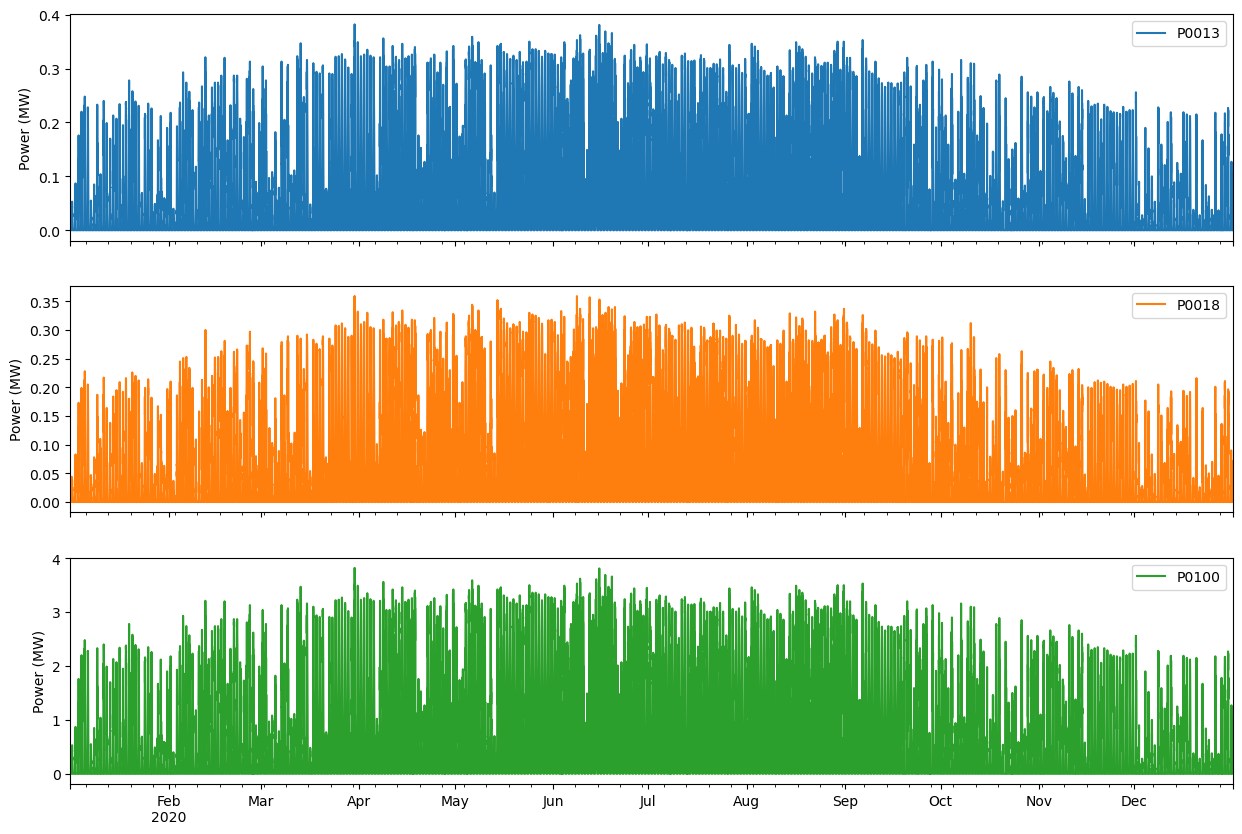

In [30]:
df_prodHT.plot(subplots=True, figsize=(15,10),ylabel ='Power (MW)');

#### Extract activated bus 

In [31]:
lowerNet_hv_bus = list(lowerNet.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index 
                               if i in lowerNet_hv_bus.index]

dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total, 
                         'lowerNet_sgenDf_copy': lowerNet.sgen.copy(deep=True) } )

#### Create daylight period mask 

In [32]:
daylight_mask = (df_prodHT.P0013>0)|(df_prodHT.P0018>0)|(df_prodHT.P0100>0)|(df_prod_bt_total.Prod_BT>0)

#### Run Power flow for each instant

In [33]:
list_max_vm_pu, list_index_max_vm_pu = [], []

# tdqm_kwargs1 = dict({'total':len(df_prodHT['P0013']),# keywords argument for tqdm
#               'dynamic_ncols':True})

# For the following loop , Could have used list comprehension or map 
# i.e list_max_vm_pu = [max_vm_pu_at(lowerNet, elm_period, lowerNet_hv_activated_bus) for elm_period in df_prodHT['P0013'].index) 
# however, it wouldn't have given an idea of the execution time as the for loop does


for elm_period in tqdm(per_index[daylight_mask]):
    
    # Get the maximum voltage magnitude of all activated bus to a list
    list_max_vm_pu.append(oriFc.run_powerflow_at(lowerNet, 
                                                 elm_period, 
                                                 lowerNet_hv_activated_bus, 
                                                 sum_max_main_network,
                                                 dict_df_sgenLoad ))
    
    ##### [STLaurentDeJourdes_2](STLaurentDeJourdes_2.ipynb)


100%|██████████| 27255/27255 [06:22<00:00, 71.33it/s]


#### Plot the maximum voltage on the network 

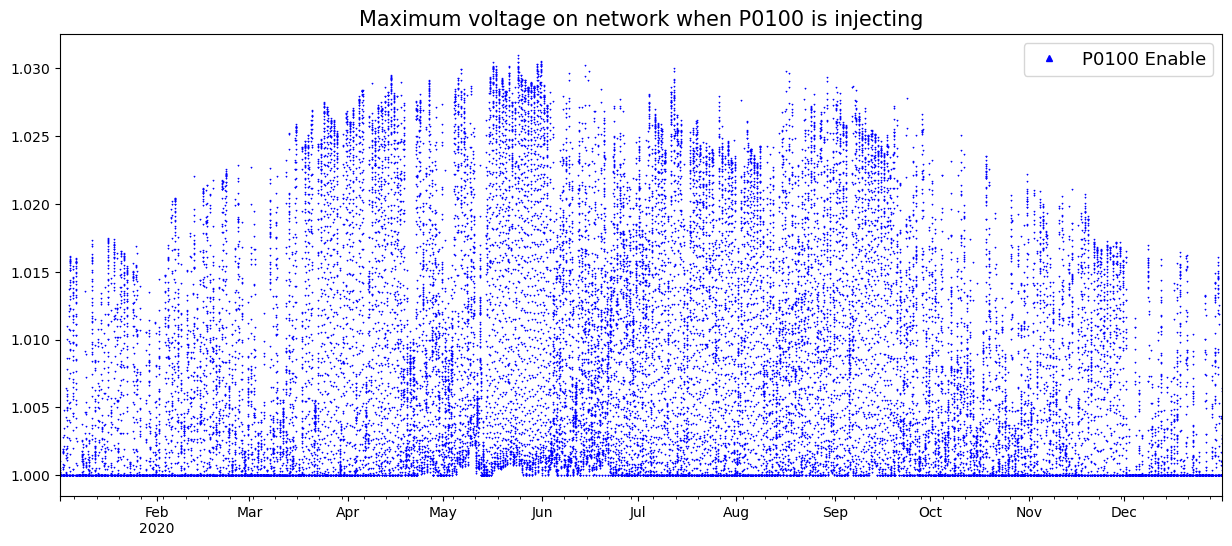

In [45]:
max_vm_pu_df = pd.DataFrame(data=np.array(list_max_vm_pu)[:,0], 
                            index=np.array(list_max_vm_pu)[:,1], 
                            columns=['max_vm_pu'])
fig, axx = plt.subplots(figsize=(15,6))
max_vm_pu_df.plot(ax=axx, style='b^',markersize=0.5, label=f'{ctrld_HvProd_name} Enable')

plt.legend([f'{ctrld_HvProd_name} Enable'], fontsize=13, markerscale=10)
plt.title(f'Maximum voltage on network when {ctrld_HvProd_name} is injecting', fontsize=15);
# plt.xlim(['2020 01 01', '2020 01 03'])

### Find connection between the HV producers and the elements in the network

In [46]:
lowerNet1=pp.from_pickle(lowerNet_file_loc) #  Reload network with new name 

In [47]:
lowerNet1.sgen[lowerNet1.sgen.name.notna()]

name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
21  P0013   51   0.0     0.0     NaN      1.0        True  wye   
22  P0018   46   0.0     0.0     NaN      1.0        True  wye   
23  P0100    7   0.0     0.0     NaN      1.0        True  wye   

    current_source  max_p_mw  
21            True      0.39  
22            True      0.40  
23            True      4.26

In [48]:
hvSgen_bus_number = lowerNet1.sgen[lowerNet1.sgen.name.notna()].bus

#### Hv producenr connected to bus 51

In [49]:
oriFc.check_bus_connection(lowerNet, [list(hvSgen_bus_number)[0]], attr_list)

----------******   Bus 51 net.bus.name ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
51   51   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******   Bus 51 net.switch.bus ******-------
    bus  element et  type  closed name  z_ohm
42   51       49  b  None    True  jdb    0.0 





In [50]:
oriFc.check_bus_connection(lowerNet, [49], attr_list)

----------******   Bus 49 net.bus.name ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
49   49   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******   Bus 49 net.switch.bus ******-------
    bus  element et  type  closed                           name  z_ohm
41   49       50  b  None    True  Cellule Fermée(manuelle) 8263    0.0 





In [51]:
oriFc.check_bus_connection(lowerNet, [50], attr_list)

----------******   Bus 50 net.bus.name ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
50   50   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******   Bus 50 net.line.from_bus ******-------
    name        std_type  from_bus  to_bus  length_km  r_ohm_per_km  \
81  None  Alu150_C33-226        50     307   0.232407         0.206   

    x_ohm_per_km  c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  \
81          0.11        310.0          0.0     0.307  1.0         1  NaN   

    in_service  
81        True   





In [52]:
oriFc.check_bus_connection(lowerNet, [307], attr_list)

----------******   Bus 307 net.bus.name ******-------
    name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
307  307   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******   Bus 307 net.line.to_bus ******-------
    name        std_type  from_bus  to_bus  length_km  r_ohm_per_km  \
81  None  Alu150_C33-226        50     307   0.232407         0.206   
82  None  Alu150_C33-226       309     307   0.137020         0.206   
83  None   Alu95_C33-226       310     307   0.011059         0.320   

    x_ohm_per_km  c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  \
81          0.11        310.0          0.0     0.307  1.0         1  NaN   
82          0.11        310.0          0.0     0.307  1.0         1  NaN   
83          0.12        210.0          0.0     0.241  1.0         1  NaN   

    in_service  
81        True  
82        True  
83        True   





#### Hv producers connected to bus 46

In [53]:
oriFc.check_bus_connection(lowerNet1, [list(hvSgen_bus_number)[1]], attr_list)

----------******   Bus 46 net.bus.name ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
46   46   20.6    b  None        True    1.05    0.95        NaN        NaN 





#### Hv producers connected to bus 7

In [54]:
oriFc.check_bus_connection(lowerNet1, [list(hvSgen_bus_number)[2]], attr_list)

----------******   Bus 7 net.bus.name ******-------
  name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
7    7   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******   Bus 7 net.switch.bus ******-------
     bus  element et  type  closed name  z_ohm
268    7      519  b  None    True  jdb    0.0 





In [55]:
oriFc.check_bus_connection(lowerNet1, [519], attr_list)

----------******   Bus 519 net.bus.name ******-------
    name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
519  519   20.6    b  None        True     NaN     NaN       1.05       0.95 





### Disconnect Producer P0100 from the network

#### Disable switch connected to bus 7 which is connected to the producer P0100


In [56]:
lowerNet1.switch.loc[lowerNet1.switch.bus==7, 'closed'] = False 
lowerNet1.switch[lowerNet1.switch.bus==7]

bus  element et  type  closed name  z_ohm
268    7      519  b  None   False  jdb    0.0

In [57]:
# Rename data in bus network because the names do not correspond to the parameters in pandapower 
lowerNet1.bus.rename({'max_vm':'max_vm_pu', 'min_vm':'min_vm_pu'}, axis=1, inplace=True)

# Delete useless parameters
lowerNet1.bus.drop(['max_vw_pu', 'min_vm_pu'], axis=1, inplace=True)

In [58]:
lowerNet1_hv_bus = list(lowerNet1.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(lowerNet1) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index1 = list(lowerNet1.res_bus.vm_pu[lowerNet1.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet1_hv_activated_bus = [i for i in activated_bus_index1 
                               if i in lowerNet1_hv_bus.index]

#### Run Power flow for each instant

In [59]:
list_max_vm_pu1 = []

for elm_period in tqdm(per_index[daylight_mask]):
    
    # Get the maximum voltage magnitude of all activated bus to a list
    list_max_vm_pu1.append(oriFc.run_powerflow_at(lowerNet1, elm_period, 
                                               lowerNet1_hv_activated_bus, 
                                               sum_max_main_network,dict_df_sgenLoad))
    

100%|██████████| 27255/27255 [05:53<00:00, 77.00it/s]


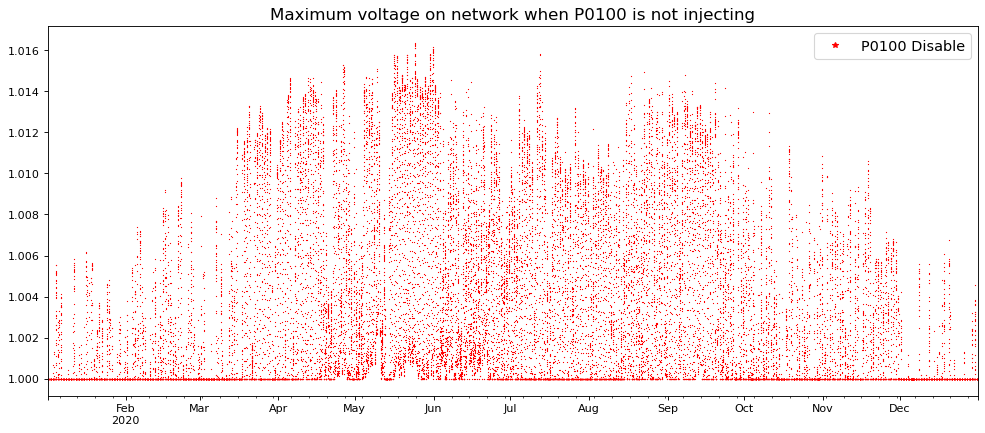

In [60]:
max_vm_pu_df = pd.DataFrame(data=np.array(list_max_vm_pu)[:,0], 
                            index=np.array(list_max_vm_pu)[:,1], 
                            columns=['max_vm_pu'])
max_vm_pu_df1 = pd.DataFrame(data=np.array(list_max_vm_pu1)[:,0], index=per_index[daylight_mask], columns=['max_vm_pu'])
fig, axx = plt.subplots(figsize=(15,6), dpi=80)
max_vm_pu_df1.plot(ax=axx, style='r*', markersize=0.5)

plt.title("Maximum voltage on network when P0100 is not injecting", fontsize=15);
plt.legend(['P0100 Disable'], fontsize=13, markerscale=10);
# plt.xlim(['2020 01 01', '2020 02 01'])

#### Plot both cases i.e. when P0100 is enable and disable

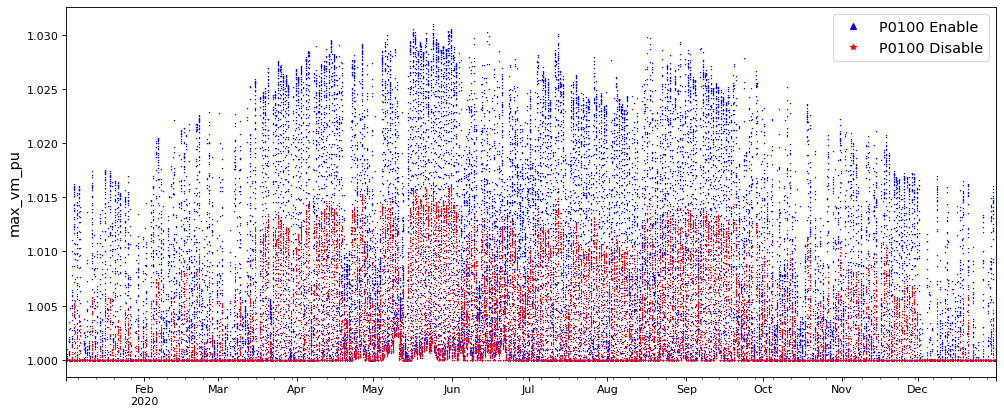

In [63]:
fig, axx = plt.subplots(figsize=(15,6), dpi=80)

max_vm_pu_df.plot(ax=axx, style='b^',markersize=0.5,)
max_vm_pu_df1.plot(ax=axx, style='r*', markersize=0.5)

plt.ylabel('max_vm_pu', fontsize=13)
plt.legend([f'{ctrld_HvProd_name} Enable',f'{ctrld_HvProd_name} Disable'],fontsize=13, markerscale=10)

# plt.xlim(['2020 01 01', '2020 02 01'])

## Run optimal power flow 

In [64]:
lowerNet2=pp.from_pickle(lowerNet_file_loc) #  Reload network with new name 
# Disable P0100
# lowerNet1.switch.loc[lowerNet1.switch.bus==7, 'closed'] = False 

# Add a controllable line to the static generators
lowerNet2.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
lowerNet2.sgen['controllable'][lowerNet2.sgen.name==ctrld_HvProd_name] = True

# Add Missing columns to be able to un an opf 
lowerNet2.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
lowerNet2.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

lowerNet2.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
lowerNet2_hv_bus = list(lowerNet1.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

# lowerNet2_hv_bus = lowerNet2_hv_bus[lowerNet1_hv_bus.max_vm_pu.notna()]

pp.runpp(lowerNet2) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(lowerNet2.res_bus.vm_pu[lowerNet2.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet2_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in lowerNet2_hv_bus.index]

dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total, 
                         'lowerNet_sgenDf_copy': lowerNet2.sgen.copy(deep=True) } )

#### Add maximum voltage constraints on the Buses in the network 

In [67]:
vm_mu_max = defAuth_hvBus_vRiseMax - 0.25/100  # Choose                           
vm_mu_min = defAuth_hvBus_vRiseMin

# lowerNet2.bus.max_vm_pu[lowerNet2.bus.max_vm_pu.notna()] = vm_mu_max
lowerNet2.bus.max_vm_pu[lowerNet2_hv_activated_bus] = vm_mu_max
lowerNet2.bus.min_vm_pu[lowerNet2_hv_activated_bus] = vm_mu_min


#### Add cost to optimal flow 

In [69]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet2.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
pp.create_poly_cost(lowerNet2, ctrld_hvProd_index,'sgen', cp1_eur_per_mw= -1)
lowerNet2.poly_cost

element    et  cp0_eur  cp1_eur_per_mw  cp2_eur_per_mw2  cq0_eur  \
0       23  sgen      0.0            -1.0              0.0      0.0   

   cq1_eur_per_mvar  cq2_eur_per_mvar2  
0               0.0                0.0

#### Rework on OPF instanciation

In [42]:
%%latex
For optimal flow, given that the sgen P0100 is contollable it allows the opt to draw the maximum power with no regard to the actual 
power provided at each instant. To eliavate this problem we would rather initialize the maximum power of the said producer with the actual prooduction. 

<IPython.core.display.Latex object>

In [70]:
int_var, list_max_vm_pu2,  list_sgen_HT = [], [], []


for elm_period in tqdm(per_index[daylight_mask]):
    
    int_var.append( oriFc.run_powerflow_at(lowerNet2, 
                                           elm_period, 
                                           lowerNet2_hv_activated_bus,
                                           sum_max_main_network,
                                           dict_df_sgenLoad,
                                           auth_max_VriseHvBus = vm_mu_max, 
                                           opf_status='Both'))

    # # Get the production of all the HT sgen after optimal power flow for each period
    # # P0100 results are save in the third collum at each period
    # list_sgen_HT.append(list(list(lowerNet2.res_sgen.p_mw[21:])))

100%|██████████| 27255/27255 [29:27<00:00, 15.42it/s]  


In [71]:
# Get actual PV production for all (3) HT producers
list_sgen_HT = [elm_result[1][0] for elm_result in int_var]

# Get maximul volatage over the network 
list_max_vm_pu2 = [elm_result[0][1] for elm_result in int_var]

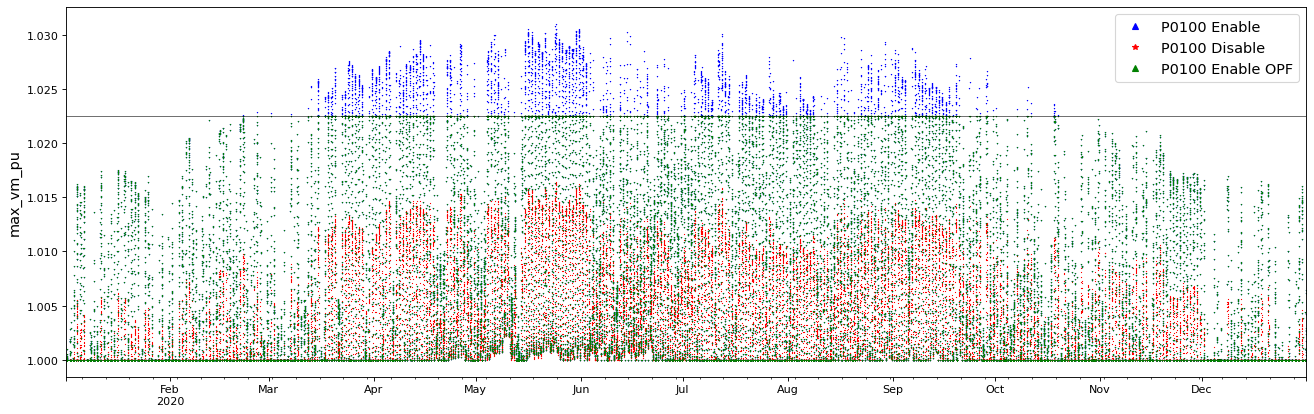

In [72]:
max_vm_pu_df2 = pd.DataFrame(data=list_max_vm_pu2, index=per_index[daylight_mask], columns=['max_vm_pu'])

fig, axx = plt.subplots(figsize=(20,6), dpi=80)
max_vm_pu_df.plot(ax=axx, style='b^',  markersize=0.5)
max_vm_pu_df1.plot(ax=axx, style='r*', markersize=0.5)
max_vm_pu_df2.plot(ax=axx, style='g^', markersize=0.5)
plt.axhline(vm_mu_max,color='k', lw=0.5)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(['P0100 Enable','P0100 Disable', 'P0100 Enable OPF'],fontsize=13, markerscale=10)

# # plt.xlim(['2020 01 01', '2020 02 01'])

In [73]:
prod_no_curt_mwh = df_prodHT.loc[daylight_mask,[ctrld_HvProd_name]].sum()*Δt  # P0100 energy production when not curtailed
prod_curt_mw = np.array(list_sgen_HT)[:,2]                          # P0100 power production after curtailement
prod_curt_mwh = prod_curt_mw.sum(axis=0)*Δt                         # P0100 energy production after curtailed
prod_curt_mw_df = pd.DataFrame(data=prod_curt_mw, index=per_index[daylight_mask])

# Percentage of power not injected into the grid during the year considered
perc_not_injected_mw = np.round((df_prodHT.loc[daylight_mask,ctrld_HvProd_name]-prod_curt_mw)*100/
                                df_prodHT.loc[daylight_mask,ctrld_HvProd_name], decimals=2)

# Percentage of energy not injected into the grid during the year considered
perc_not_injected_mwh = np.round((prod_no_curt_mwh-prod_curt_mwh)*100/prod_no_curt_mwh, decimals=2)


prod_curt_mw_df[prod_curt_mw_df<1e-6]=0 # replace lower value (lower than 1wh) by 0


perc_not_injected = pd.DataFrame(np.zeros(len(per_index)),index=per_index)

perc_not_injected[df_prodHT.P0100>0] = (100*(df_prodHT[daylight_mask].P0100[df_prodHT[daylight_mask].P0100>0] -
                                             prod_curt_mw_df[df_prodHT[daylight_mask].P0100>0].round(decimals=4).loc[:,0])/
                                        df_prodHT[daylight_mask].P0100[df_prodHT[daylight_mask].P0100>0]).values.reshape(
    (len(perc_not_injected[df_prodHT.P0100>0]),1))

print(f'{ctrld_HvProd_name} prod,   No curting  : {prod_no_curt_mwh[0]:.2f} MWh')
print(f'{ctrld_HvProd_name} prod, With curting  : {prod_curt_mwh:.2f} MWh')
print(f'Percentage of total \n      energy not injected : {perc_not_injected_mwh[0]} %')


P0100 prod,   No curting  : 5033.34 MWh
P0100 prod, With curting  : 4717.39 MWh
Percentage of total 
      energy not injected : 6.28 %


#### Some other plots

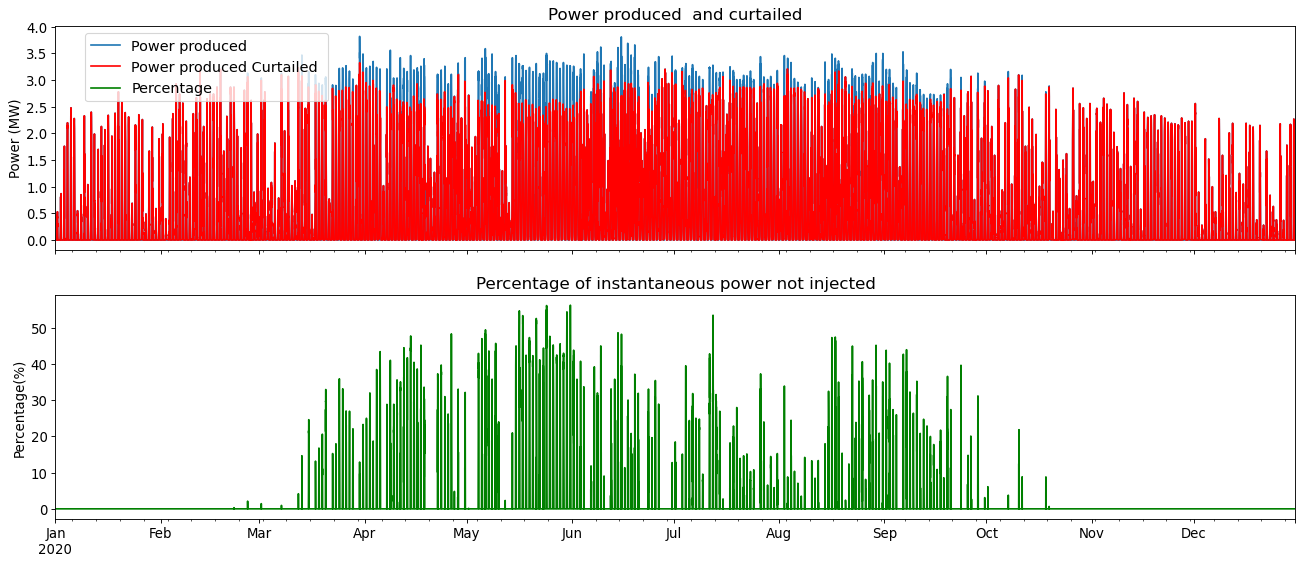

In [74]:
fig, axx = plt.subplots(2, figsize=(20,8), sharex=True, dpi=80)
df_prodHT.P0100.plot(ax=axx[0],legend=False)
prod_curt_mw_df.plot(ax=axx[0], color='red',
                     legend=False,fontsize=12,)
axx[0].set_title('Power produced  and curtailed',fontsize=15)
axx[0].set_ylabel('Power (MW)',fontsize=12)



perc_not_injected.plot(ax=axx[1], color="green", legend=False,
                       xlim=['2020 01 01', '2020 12 31'], fontsize=12,)
axx[1].set_title('Percentage of instantaneous power not injected', fontsize=15)
axx[1].set_ylabel('Percentage(%)',fontsize=12)

fig.legend(['Power produced','Power produced Curtailed ', 'Percentage'],
          loc='upper right', 
           bbox_to_anchor=(0.3, 0.88), 
           ncol=1, fontsize=13)


# plt.grid(axis='both', which='Both')

#### Some other statistics

In [75]:
perc_not_injected[perc_not_injected<1e-6]=0 # Set to zero all the percentage value lower than (1w)

int_var = (perc_not_injected>0).sum()*100/(df_prodHT[ctrld_HvProd_name]>1e-6).sum()# Actual period of production

# int_var = (perc_not_injected>0).sum()*100/len(perc_not_injected)
print('Percentage of time \n \twhen curtailement occurs :', np.round(int_var[0], decimals=2),'%')

Percentage of time 
 	when curtailement occurs : 11.13 %


#### Plot Stats about the percentage of power not injected into the grid

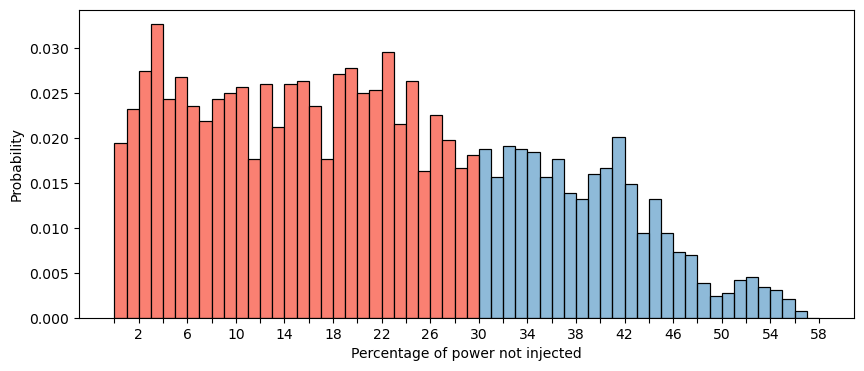

In [76]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=58, binrange=[0,58],
             stat='probability', ax=axx, cumulative= False,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        xticks=range(0,60,2), 
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);
for elm in axx.patches[:30]: elm.set_facecolor('salmon')

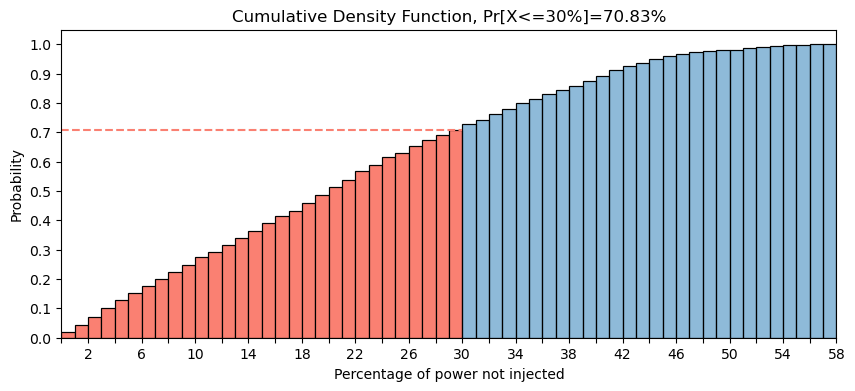

In [77]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=58, binrange=[0,58],
             stat='probability', ax=axx, cumulative=True,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        yticks=np.arange(0,1.1,.1),
        xticks=range(0,60,2),
        xlim=(0,58),
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);

perc_to_consider= 30
for elm in axx.patches[:perc_to_consider]: elm.set_facecolor('salmon')

x_maxx = axx.patches[perc_to_consider].get_x()/58
axx.axhline(axx.patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--')
plt.title(f'Cumulative Density Function, Pr[X<={perc_to_consider}%]={axx.patches[perc_to_consider-1].get_height()*100:.2f}%');

#### save results to be used in [Res_Sim_STLaurentDeJourdes](Res_Sim_STLaurentDeJourdes.ipynb)

In [506]:
var_STLaurentDeJourdes = dict({'list_max_vm_pu': list_max_vm_pu,
                              'list_index_max_vm_pu':list_index_max_vm_pu,
                              'list_max_vm_pu1':list_max_vm_pu1,
                              'list_max_vm_pu2':list_max_vm_pu2,
                              'list_sgen_HT':list_sgen_HT} )



with open(simResult_folder+"STLaurentDeJourdes.pkl",'wb') as file: 
    pickle.dump(var_STLaurentDeJourdes,file)
